<a href="https://colab.research.google.com/github/karizeviecelli/predicao-equipamento/blob/main/Projeto_Maquinas_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importação de bibliotecas e carregamento dos dados

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [2]:

# Carregar o dataset
df = pd.read_csv('/content/sample_data/maquinas.csv')  # ajuste o caminho se necessário
df.head()


,preco,potencia,durabilidade,tecnologia,peso,necessidade_energia,requere_manutencao,iot,protecao_corrente,sistema_refri,garantia,com_software,classe,status
0,47950.00,7000,3,1,2,sim,nao,sim,nao,nao,0,nao,C,sem manutenção
1,34930.00,4900,3,1,2,nao,nao,nao,nao,nao,0,nao,C,sem manutenção
2,22481.43,2581,2,1,1,sim,sim,nao,nao,nao,1,S,A,revisado
3,35000.00,9500,3,1,2,sim,nao,nao,nao,nao,3,sim,C,sem manutenção
4,37730.00,6930,4,1,2,nao,nao,nao,N,nao,1,nao,C,revisado


## 2. Análise exploratória e limpeza de dados

In [3]:

# Verificar tipos e valores ausentes
print(df.dtypes)
print(df.isnull().sum())

# Exibir estatísticas básicas
df.describe(include='all')


preco                  float64
potencia                 int64
durabilidade             int64
tecnologia               int64
peso                     int64
necessidade_energia     object
requere_manutencao      object
iot                     object
protecao_corrente       object
sistema_refri           object
garantia                 int64
com_software            object
classe                  object
status                  object
dtype: object
preco                  0
potencia               0
durabilidade           0
tecnologia             0
peso                   0
necessidade_energia    0
requere_manutencao     0
iot                    0
protecao_corrente      0
sistema_refri          0
garantia               0
com_software           0
classe                 0
status                 0
dtype: int64


,preco,potencia,durabilidade,tecnologia,peso,necessidade_energia,requere_manutencao,iot,protecao_corrente,sistema_refri,garantia,com_software,classe,status
count,677.000000,677.000000,677.000000,677.000000,677.000000,677,677,677,677,677,677.000000,677,677,677
unique,NaN,NaN,NaN,NaN,NaN,4,4,4,4,4,NaN,4,5,9
top,NaN,NaN,NaN,NaN,NaN,sim,nao,nao,nao,nao,NaN,nao,C,em manutenção
freq,NaN,NaN,NaN,NaN,NaN,497,477,378,557,395,NaN,460,400,226
mean,53227.572260,5246.734121,3.127031,1.676514,2.144756,NaN,NaN,NaN,NaN,NaN,1.100443,NaN,NaN,NaN
std,35068.538474,2509.361045,1.897942,2.207490,2.401249,NaN,NaN,NaN,NaN,NaN,2.331026,NaN,NaN,NaN
min,3376.760000,1650.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
25%,33950.000000,3520.000000,2.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
50%,44030.000000,4500.000000,3.000000,1.000000,2.000000,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
75%,59500.000000,6400.000000,3.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN


## 3. Tratamento de outliers com mediana

In [4]:

df_out = df.copy()
numericas = df_out.select_dtypes(include=['int64', 'float64']).columns

for col in numericas:
    Q1 = df_out[col].quantile(0.25)
    Q3 = df_out[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    mediana = df_out[col].median()

    df_out[col] = np.where(
        (df_out[col] < limite_inferior) | (df_out[col] > limite_superior),
        mediana,
        df_out[col]
    )


## 4. Codificação de variáveis categóricas

In [5]:

df_codificado = df_out.copy()
categoricas = df_codificado.select_dtypes(include='object').columns
label_encoders = {}

for col in categoricas:
    le = LabelEncoder()
    df_codificado[col] = le.fit_transform(df_codificado[col])
    label_encoders[col] = le


## 5. Normalização das variáveis numéricas

In [6]:

scaler = MinMaxScaler()
df_normalizado = df_codificado.copy()
df_normalizado[numericas] = pd.DataFrame(
    scaler.fit_transform(df_normalizado[numericas]),
    columns=numericas,
    index=df_normalizado.index
)


## 6. Separação entre variáveis preditoras e alvo

In [7]:

# Para regressão
X_reg = df_normalizado.drop(columns=['preco', 'classe', 'status'])
y_reg = df_normalizado['preco']

# Para classificação
X_class = df_normalizado.drop(columns=['status', 'classe', 'preco'])
y_class = df_normalizado['status']


## 7. Modelos de regressão e classificação

In [8]:

Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

modelo_rf = RandomForestRegressor(n_estimators=100, random_state=42)
modelo_rf.fit(Xr_train, yr_train)
yr_pred = modelo_rf.predict(Xr_test)

rmse = np.sqrt(mean_squared_error(yr_test, yr_pred))
r2 = r2_score(yr_test, yr_pred)

print("Random Forest Regressor:")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


Random Forest Regressor:
RMSE: 0.1413
R²: 0.4500


In [10]:

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

modelo_rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf_clf.fit(Xc_train, yc_train)
yc_pred = modelo_rf_clf.predict(Xc_test)

acc = accuracy_score(yc_test, yc_pred)
print("Random Forest Classifier:")
print(f"Acurácia: {acc:.2f}")
print("Matriz de Confusão:")
print(confusion_matrix(yc_test, yc_pred))
print("Relatório de Classificação:")
print(classification_report(yc_test, yc_pred))


Random Forest Classifier:
Acurácia: 0.35
Matriz de Confusão:
[[ 0  0  0  3  0  0  0  0  1]
 [ 0  0  0  5  0  1  0  0  0]
 [ 0  0  1  1  0  3  0  0  0]
 [ 0  0  0 28  0  9  0  0  4]
 [ 0  0  0  2  0  1  0  0  5]
 [ 0  0  0 10  0  7  0  0  7]
 [ 1  0  0  1  0  2  0  0  1]
 [ 0  0  0  1  0  0  0  0  1]
 [ 0  0  0 18  0  9  0  2 12]]
Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         6
           2       1.00      0.20      0.33         5
           3       0.41      0.68      0.51        41
           4       0.00      0.00      0.00         8
           5       0.22      0.29      0.25        24
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           8       0.39      0.29      0.33        41

    accuracy                           0.35       136
   macro avg       0.22      0.16      0.16 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 8. Importância das variáveis preditoras

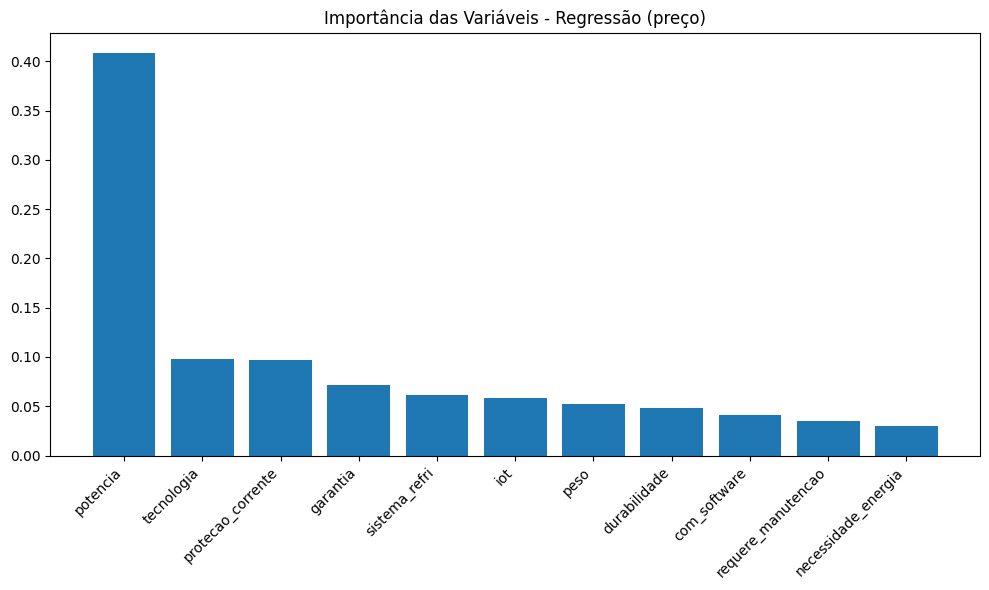

In [11]:

importancias_reg = modelo_rf.feature_importances_
nomes_reg = X_reg.columns
indices_reg = np.argsort(importancias_reg)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Regressão (preço)")
plt.bar(range(len(importancias_reg)), importancias_reg[indices_reg])
plt.xticks(range(len(importancias_reg)), nomes_reg[indices_reg], rotation=45, ha='right')
plt.tight_layout()
plt.show()


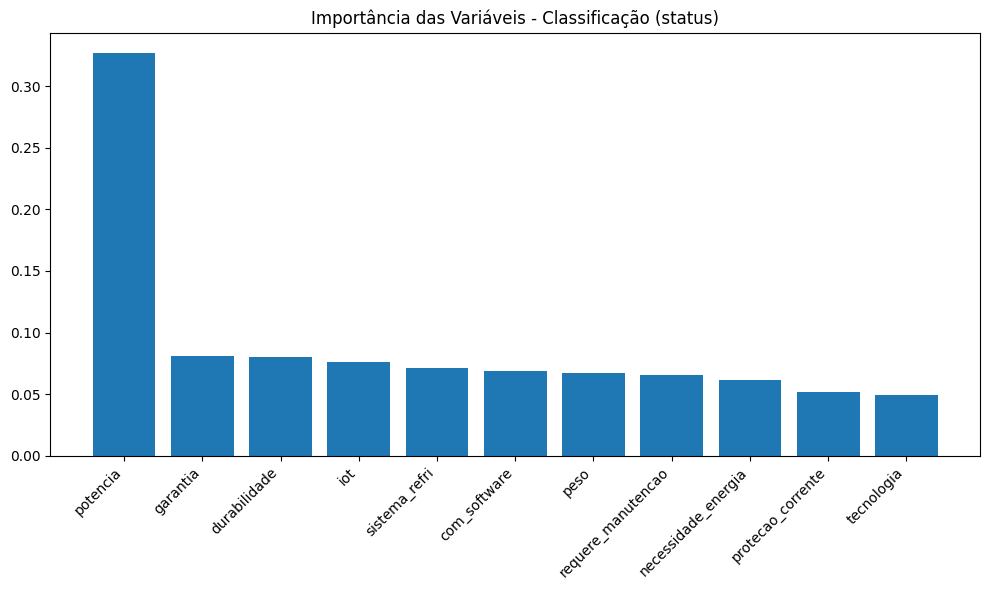

In [12]:

importancias_clf = modelo_rf_clf.feature_importances_
nomes_clf = X_class.columns
indices_clf = np.argsort(importancias_clf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Importância das Variáveis - Classificação (status)")
plt.bar(range(len(importancias_clf)), importancias_clf[indices_clf])
plt.xticks(range(len(importancias_clf)), nomes_clf[indices_clf], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 📊 Visualizações Extras

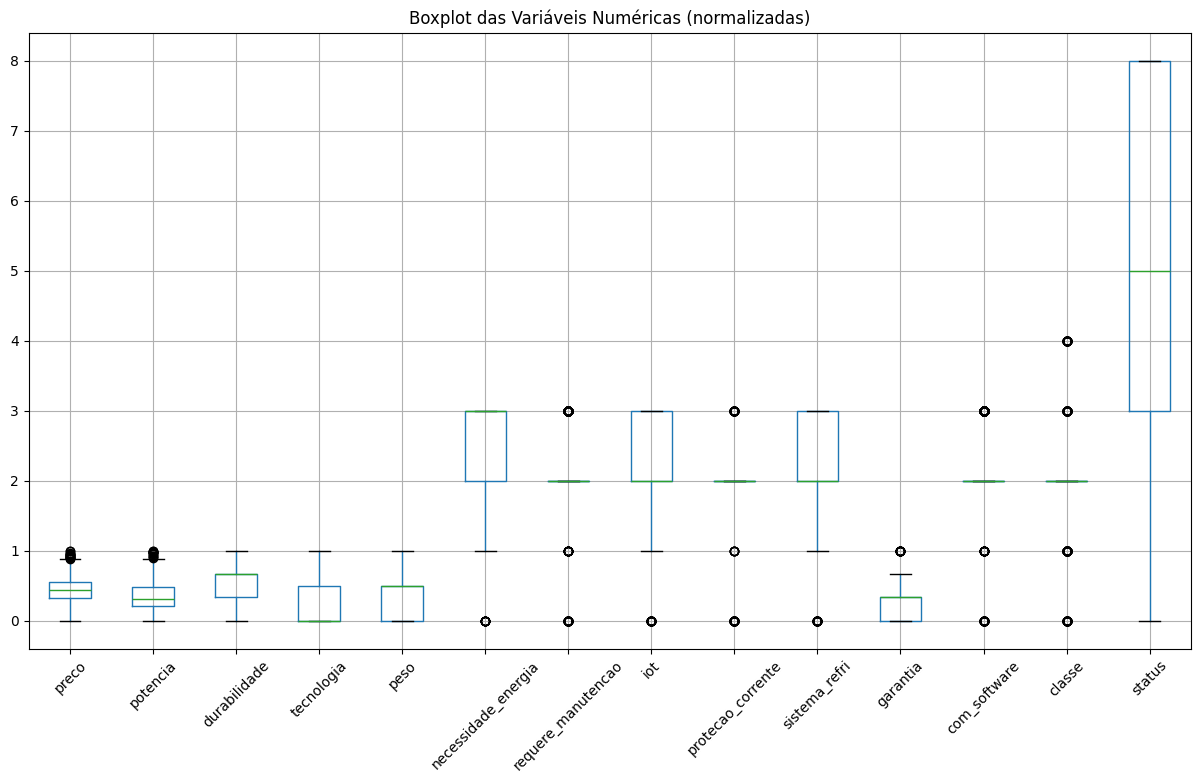

In [13]:

# Boxplot das variáveis numéricas
plt.figure(figsize=(15, 8))
df_normalizado.boxplot(rot=45)
plt.title("Boxplot das Variáveis Numéricas (normalizadas)")
plt.show()


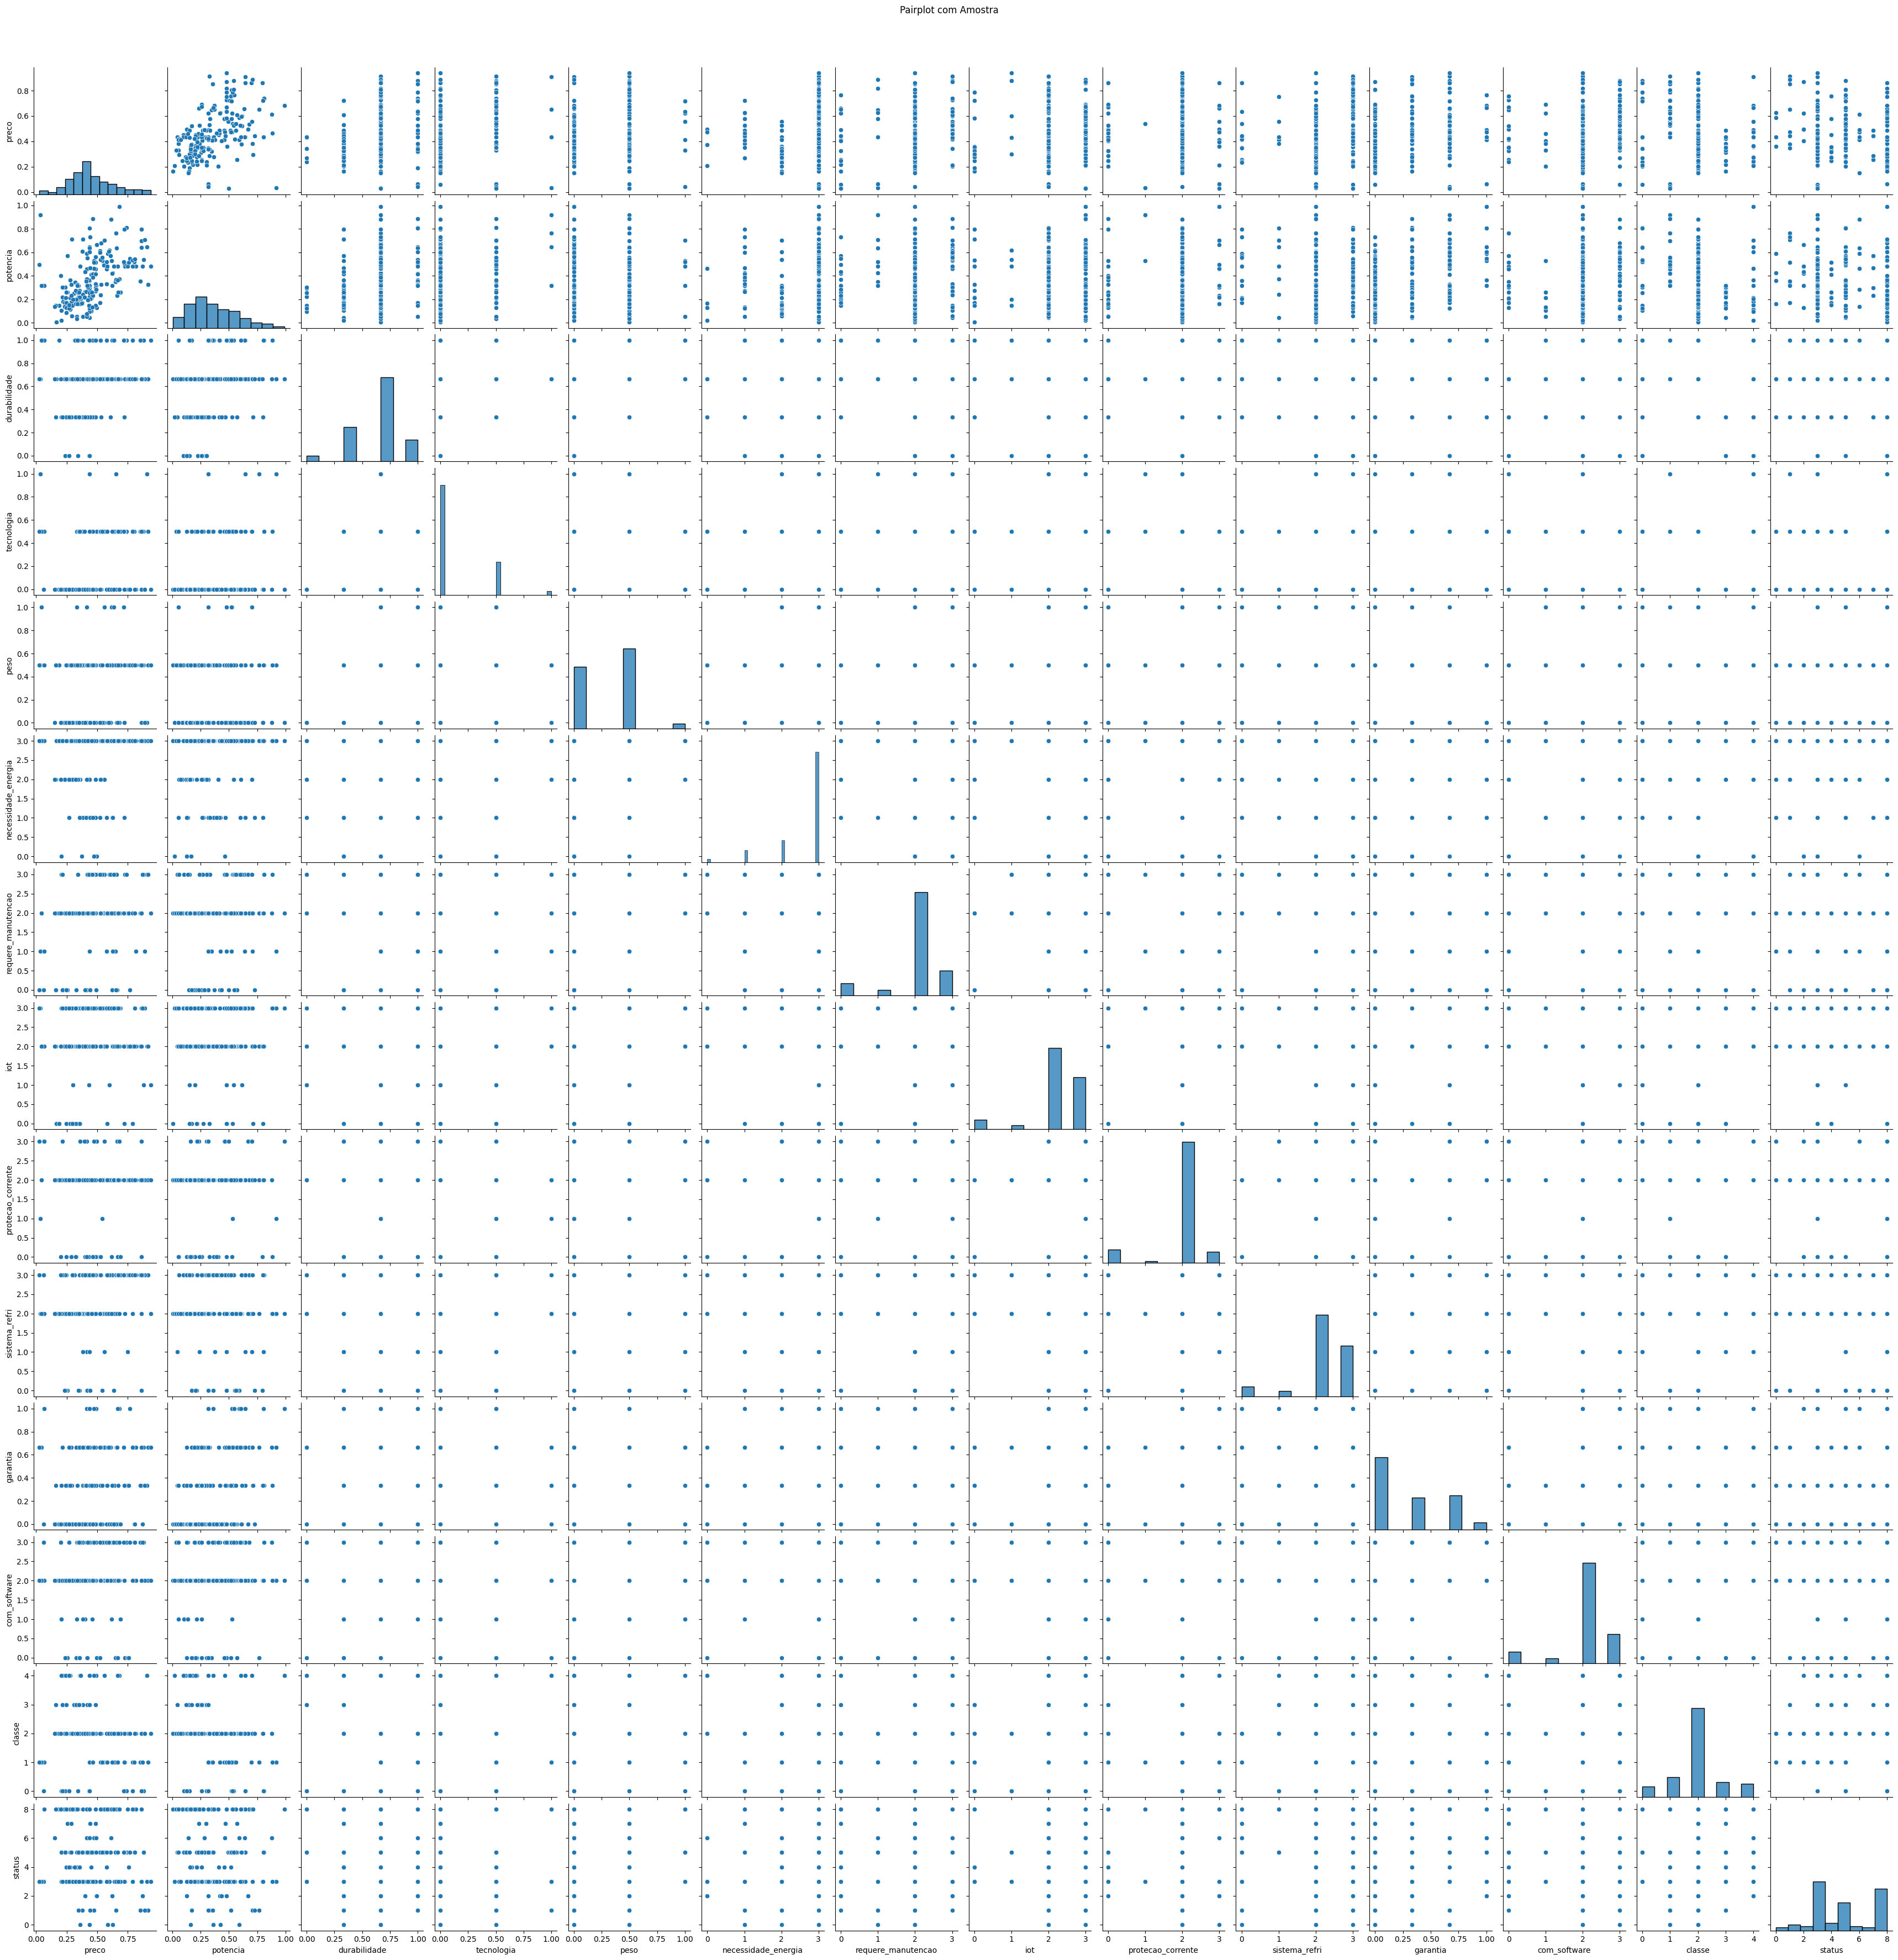

In [14]:

# Pairplot com amostra para não travar
sns.pairplot(df_normalizado.sample(n=200, random_state=42))
plt.suptitle("Pairplot com Amostra", y=1.02)
plt.show()


## 💾 Exportação do DataFrame Tratado

In [15]:

# Exportar o DataFrame tratado
df_normalizado.to_csv("maquinas_tratado.csv", index=False)
print("Arquivo 'maquinas_tratado.csv' exportado com sucesso.")


Arquivo 'maquinas_tratado.csv' exportado com sucesso.


In [16]:

import joblib

# Exportar modelo de regressão (previsão de preço)
joblib.dump(modelo_rf, "modelo_preco.pkl")
print("Modelo salvo como modelo_preco.pkl")


Modelo salvo como modelo_preco.pkl
